In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt

## Data

In [2]:
df = pd.read_csv(r"snowfall.csv")
df.tail()

,year_start,year_end,total_snow
95,2015,2016,698.0
96,2016,2017,703.0
97,2017,2018,738.0
98,2018,2019,543.0
99,2019,2020,530.0


Text(0, 0.5, 'Inches of Snow')

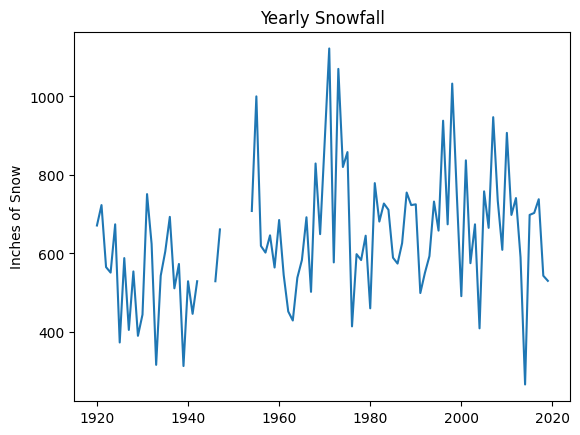

In [3]:
plt.plot(df['year_start'],df["total_snow"])
plt.title("Yearly Snowfall")
plt.ylabel('Inches of Snow')

### Differencing (d)

In [4]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the differenced series
result = adfuller(df['total_snow'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -4.43290854997994
p-value: 0.0002594590347999944


The ADF test shows that the data is stationary without any differencing

### ACF and PACF for choosing p, q

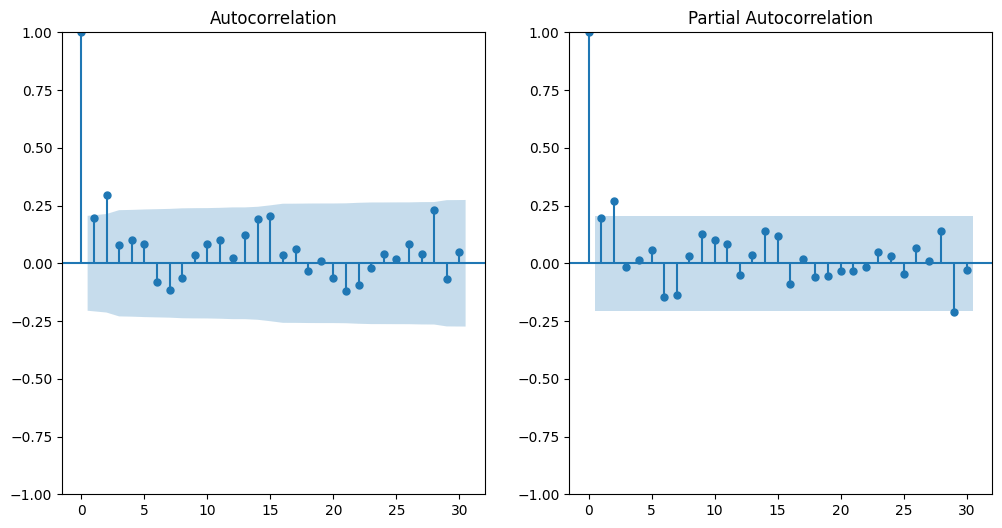

In [5]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df['total_snow'].dropna(), lags=30, ax=plt.gca())  # ACF plot
plt.subplot(122)
plot_pacf(df['total_snow'].dropna(), lags=30, ax=plt.gca())  # PACF plot
plt.show()

### Testing ARIMA

In [6]:
model221 = ARIMA(df['total_snow'], order=(2, 1, 1))
model221_fit = model221.fit()

print(model221_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             total_snow   No. Observations:                  100
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -582.916
Date:                Tue, 03 Dec 2024   AIC                           1173.833
Time:                        13:20:42   BIC                           1184.213
Sample:                             0   HQIC                          1178.033
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1137      0.125      0.907      0.364      -0.132       0.359
ar.L2          0.2433      0.118      2.056      0.040       0.011       0.475
ma.L1         -0.9596      0.050    -19.325      0.0

C:\Users\sulli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## Evaluating Predictions Accuracy

C:\Users\sulli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sulli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted: 822.834, Actual: 491.000
Predicted: 665.703, Actual: 837.000
Predicted: 650.263, Actual: 575.000
Predicted: 712.729, Actual: 674.000
Predicted: 645.582, Actual: 409.000
Predicted: 626.521, Actual: 758.000
Predicted: 593.898, Actual: 665.000
Predicted: 695.588, Actual: 947.000
Predicted: 709.902, Actual: 734.000
Predicted: 775.717, Actual: 609.000
Predicted: 687.282, Actual: 907.000
Predicted: 692.898, Actual: 698.000
Predicted: 758.888, Actual: 741.000
Predicted: 702.082, Actual: 590.000
Predicted: 693.704, Actual: 266.000
Predicted: 583.993, Actual: 698.000
Predicted: 554.590, Actual: 703.000
Predicted: 682.401, Actual: 738.000
Predicted: 689.859, Actual: 543.000
Predicted: 671.584, Actual: 530.000
Test RMSE: 178.936


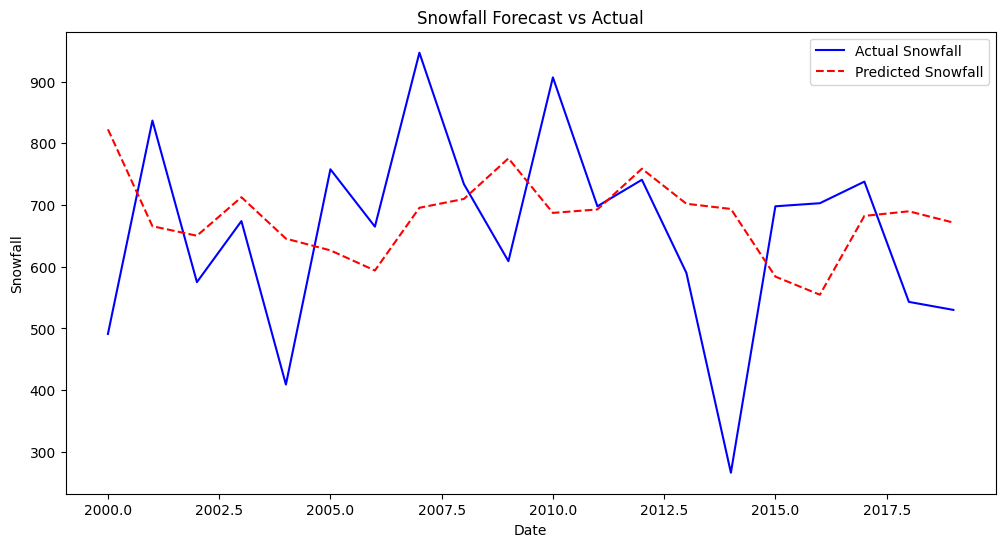

In [ ]:
df.set_index('year_start', inplace=True)

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df['total_snow'][:train_size], df['total_snow'][train_size:]

# Initialize history with training data
history = [x for x in train]
predictions = []

# Walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2, 1, 1))  # Example: ARIMA(p,d,q)
    model_fit = model.fit()
    
    # Forecast the next value (one step ahead)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    
    # Append the actual observed value to the history
    obs = test.iloc[t]
    history.append(obs)
    
    # Print the predicted vs actual value
    print(f"Predicted: {yhat:.3f}, Actual: {obs:.3f}")

# Evaluate the forecast
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse:.3f}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual Snowfall', color='blue')
plt.plot(test.index, predictions, label='Predicted Snowfall', color='red', linestyle='dashed')
plt.title('Snowfall Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Snowfall')
plt.legend()
plt.show()


Using the standard ARIMA model, we get RMSE=179. We will use a difference equation model for the time series rather than the standard ARIMA model. we will use the equation x_n = a_n*x_{n-1}/(1+x_{n-1}+x_{n-2}) where a_n is a linear function on n

In [9]:
if 'year_start' not in df.columns:
    df['year_start'] = df.index

# Beverton - Holt Time Series Model

In [10]:
import numpy as np
from scipy.optimize import minimize

# Drop NaN values from the train dataset
train_clean = train.dropna()


## Mathematical Functions

In [11]:

# Linear function for a_n 
def linear_function(n, m, b):
    return m * n + b

# Rational Non-autonomus Difference Equation similar to Beverton-Holt
def beverton_holt(m, b, x_t, x_tm1, n):
    a_n = linear_function(n, m, b)
    return (a_n * x_t) / (1 + x_t + x_tm1)

# Objective function for optimization
def objective_function_beverton_holt(params, history, actual_data):
    m, b = params[0], params[1]
    
    predictions = []
    for i in range(1, len(history)):   
        prediction = beverton_holt(m, b, history.iloc[i], history.iloc[i-1], i)
        predictions.append(prediction)
    
    # RMSE calculation
    rmse = sqrt(mean_squared_error(actual_data[1:], predictions))  # Skip first point due to lag
    return rmse


## Optimizing Parameters

In [13]:

# Initial values for m and b
initial_params = [0.1, 10.0]  
result = minimize(objective_function_beverton_holt, initial_params, args=(train_clean, train_clean))

# Best m and b parameters 
best_m, best_b = result.x
print(f"Best m: {best_m:.4f}, Best b: {best_b:.4f}")

# Generate predictions 
predictions_beverton_holt = []
for i in range(len(test)):  # Iterate over the whole test data (test)
    # For the first value, set prediction to NaN (as there's no previous value)
    prediction = beverton_holt(best_m, best_b, test.iloc[i], test.iloc[i-1], i) if i > 0 else np.nan
    predictions_beverton_holt.append(prediction)

# Convert the predictions list to a pandas series with the same index as the original data
predicted_series = pd.Series(predictions_beverton_holt, index=test.index)
predicted_series = predicted_series.replace({None: np.nan})


Best m: 6.2449, Best b: 1042.3498


## Plotting Results

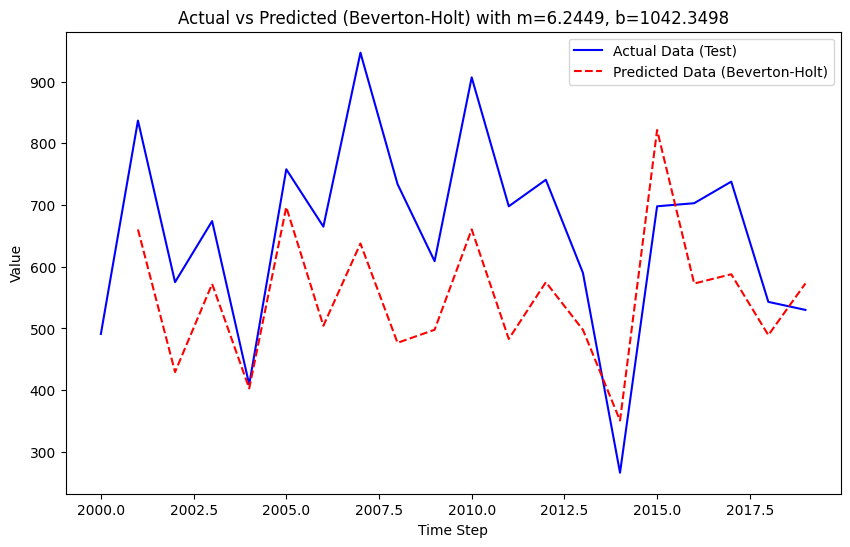

RMSE (Beverton-Holt) on test data: 158.3784


In [16]:

# Plot actual vs predicted values (Beverton-Holt)
plt.figure(figsize=(10, 6))
plt.plot(test, label='Actual Data (Test)', color='blue')  # Plot actual data as a line
plt.plot(predicted_series, label='Predicted Data (Beverton-Holt)', color='red', linestyle='dashed')
plt.title(f"Actual vs Predicted (Beverton-Holt) with m={best_m:.4f}, b={best_b:.4f}")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

# Evaluate model performance on test data
rmse_beverton_holt = sqrt(mean_squared_error(test[1:], predictions_beverton_holt[1:]))
print(f"RMSE (Beverton-Holt) on test data: {rmse_beverton_holt:.4f}")


## The difference equation model has RMSE=158, which is an 11% improvement.